# Using MLP to Classify Patient Category

### 1. Load and Pre-process the Image Dataset

#### Importing required libraries

In [4]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA

#### Define Class Names and Paths

In [6]:
#maps each category of ECG images to a label for classificaction
class_names = {
    'ECG Images of Myocardial Infarction Patients': 0,
    'ECG Images of Patient that have abnormal heartbeat': 1,
    'ECG Images of Patient that have History of MI': 2,
    'Normal Person ECG Images': 3
}
#defines paths to original dataset and augmented dataset
original_data_path = 'ECG_Image_dataset'
output_data_path = 'ECG_Image_dataset_augmented'
#specify the image size for resizing
img_size = (128, 128)
#creates an output directory if it does not already exist
os.makedirs(output_data_path, exist_ok=True)

#### Define Image Augmentation Function

In [8]:
#function to apply augmentation techniques to an input image
def augment_image(image, noise_std_dev=0.01):
    #randomly rotate the image by ±5 degrees
    angle = random.uniform(-5, 5)
    rotated_image = image.rotate(angle)
    #applying random horizontal and vertical shifts up to ±10%
    max_shift_x = int(0.1 * rotated_image.size[0])
    max_shift_y = int(0.1 * rotated_image.size[1])
    shift_x = random.randint(-max_shift_x, max_shift_x)
    shift_y = random.randint(-max_shift_y, max_shift_y)
    #apply affine transformation for shifting
    shifted_image = rotated_image.transform(
        rotated_image.size,
        Image.AFFINE,
        (1, 0, shift_x, 0, 1, shift_y)
    )
    #adds gaussian noise to th eimage to mimic real-world noise
    noisy_image = np.array(shifted_image) #convert to numpy array
    noise = np.random.normal(0, noise_std_dev, noisy_image.shape) #generate noise
    noisy_image = np.clip(noisy_image + noise * 255, 0, 255).astype(np.uint8) #add noise
    noisy_image = Image.fromarray(noisy_image) #converts back to PIL image format
    #randmly adjusts brightness of the image
    enhancer = ImageEnhance.Brightness(noisy_image)
    bright_image = enhancer.enhance(random.uniform(0.7, 1.1))  # Adjust brightness
    #randomly adjusts contrast of the image
    enhancer = ImageEnhance.Contrast(bright_image)
    final_image = enhancer.enhance(random.uniform(0.7, 1.3))  # Adjust contrast
    #returns the augmented image
    return final_image

#### Function to Load and Augment the Images

In [10]:
#function to load, process, augment, and save images in TRAIN folder
def load_and_augment_images(data_path, output_path, image_size, class_names, folder_type):
    images = []
    labels = []

    #loops through each class folder
    for class_name, label in class_names.items():
        original_class_path = os.path.join(data_path, folder_type, class_name)
        augmented_class_path = os.path.join(output_path, folder_type, class_name)
        #creates the output folder for the class if it doesn't already exist
        os.makedirs(augmented_class_path, exist_ok=True)
        
        #process each image in the original dataset
        for img_name in os.listdir(original_class_path):
            img_path = os.path.join(original_class_path, img_name)

            try:
                #loads original image, convert to grayscale, and resize
                img = Image.open(img_path).convert('L').resize(image_size)
                
                #saves the original image in the augmented dataset folder
                original_save_path = os.path.join(augmented_class_path, f"original_{img_name}")
                img.save(original_save_path)

                #flatten the original image and add to the list
                img_array = np.array(img) / 255.0  #normalize
                img_flat = img_array.flatten()  #flatten the image
                images.append(img_flat)
                labels.append(label)

                #generates and saves the augmented image
                augmented_img = augment_image(img)
                augmented_save_path = os.path.join(augmented_class_path, f"augmented_{img_name}")
                augmented_img.save(augmented_save_path)

                #flattens the augmented image and add to the list
                augmented_img_array = np.array(augmented_img) / 255.0  # Normalize
                augmented_img_flat = augmented_img_array.flatten()  # Flatten the image
                images.append(augmented_img_flat)
                labels.append(label)
            #handles any errors encountered while processing the image
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    #converts the lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    print(f"Total images loaded and augmented: {len(images)}, Total labels loaded: {len(labels)}")
    return images, labels #returns the processed image data and labels


#### Load and Augment Training and Testing Data

In [12]:
#loads, process, augment, and save images
train_images, train_labels = load_and_augment_images(original_data_path, output_data_path, img_size, class_names, 'train')
test_images, test_labels = load_and_augment_images(original_data_path, output_data_path, img_size, class_names, 'test')

#checks the shape
print(f"Augmented training data shape: {train_images.shape}, Labels shape: {train_labels.shape}")
print(f"Augmented testing data shape: {test_images.shape}, Labels shape: {test_labels.shape}")


Total images loaded and augmented: 1856, Total labels loaded: 1856
Total images loaded and augmented: 896, Total labels loaded: 896
Augmented training data shape: (1856, 16384), Labels shape: (1856,)
Augmented testing data shape: (896, 16384), Labels shape: (896,)


#### Handle Class Imabalnce with Random Oversampling

In [14]:
#initializes RandomOverSampler for handling class imbalance
oversampler = RandomOverSampler(random_state=42)
#apply oversampling to the training images and labels
train_images_resampled, train_labels_resampled = oversampler.fit_resample(train_images, train_labels)

Training samples for class 0: 568
Training samples for class 1: 568
Training samples for class 2: 568
Training samples for class 3: 568
Test samples for class 0: 224
Test samples for class 1: 224
Test samples for class 2: 224
Test samples for class 3: 224


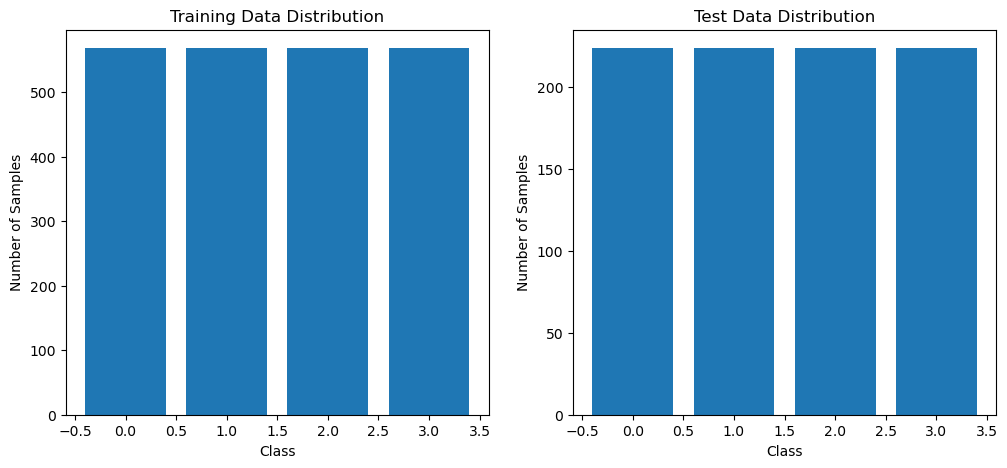

In [15]:
#asssuming train_labels and test_labels are arrays of class indices
train_class_counts = np.bincount(train_labels_resampled)
test_class_counts = np.bincount(test_labels)

#prints the counts for each class
for class_id, count in enumerate(train_class_counts):
    print(f"Training samples for class {class_id}: {count}")
for class_id, count in enumerate(test_class_counts):
    print(f"Test samples for class {class_id}: {count}")

#plot the distribution of data
plt.figure(figsize=(12, 5))
#plots training data distribution
plt.subplot(1, 2, 1)
plt.bar(range(len(train_class_counts)), train_class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Training Data Distribution')
#plots test data distribution
plt.subplot(1, 2, 2)
plt.bar(range(len(test_class_counts)), test_class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Test Data Distribution')
#displays the plots
plt.show()


#### Dislay Sample Images from Augmented Training Data

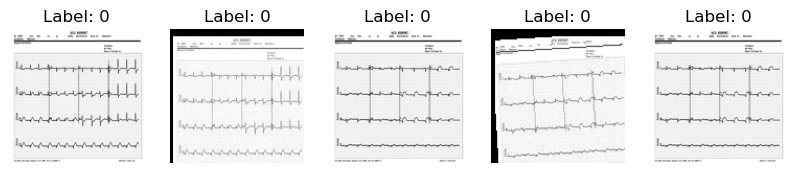

In [17]:
#function to display few images from the augmented training dataset
def display_sample_images(images, labels, image_size, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        #reshapes the images back to the original dimensions
        img = images[i].reshape(image_size)
        
        #plots the image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    
    plt.show()
#calls the function
display_sample_images(train_images, train_labels, img_size)

#### Apply PCA for Dimensionality Reduction

In [19]:
#initializes PCA (Principal Component Analysis) to reduce dimensionality
pca = PCA(n_components=256)  # Reduce dimensions to 256
#applying PCA to the resampled training images
X_train_pca = pca.fit_transform(train_images_resampled)
#transforms the test images using the same PCA transformation matrix
X_test_pca = pca.transform(test_images)

#### On-hot Encoding the Labels

In [21]:
#one-hot encoding the train and test labels 
train_labels_one_hot = to_categorical(train_labels_resampled, num_classes=4)
test_labels_one_hot = to_categorical(test_labels, num_classes=4)

#### Compute Class Weights for Imbalanced Data

In [23]:
#computes the class weights to handle class imbalance in the training data
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
#converts the computed class weights into a dictionary
class_weight_dict = dict(enumerate(class_weights))

### 2. Create and Compile the MLP Model

In [25]:
def create_mlp_model():
    #initialize the sequential model
    model = models.Sequential()
    model.add(layers.Input(shape=((256),))) #input layer expects 256 features (PCA reduced features)
    model.add(layers.Dense(256, activation=layers.LeakyReLU(negative_slope=0.1),
                           kernel_regularizer=regularizers.l2(0.001))) #first dense hidden layer with 256 units
    #batch normalization and dropout layers
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation=layers.LeakyReLU(negative_slope=0.1),
                           kernel_regularizer=regularizers.l2(0.001))) #second dense hidden layer with 128 units
    #batch normalization and dropout layers
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(4, activation='softmax'))  #output layer for classification
    #compiles the model using Adam optimizer with a small learning rate (0.0005)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.save('mlp.keras')
    #returns the constructed model
    return model

#create the MLP model by calling the function defined earlier
mlp_model = create_mlp_model()
#summary of the model architecture
mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,740 (393.52 KB)

 Trainable params: 99,972 (390.52 KB)

 Non-trainable params: 768 (3.00 KB)

### 3. Train the MLP Model

In [27]:
#EarlyStopping callback stops training if the validation accuracy does not improve for 10 consecutive epochs
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
#reduces the learning rate by a factor of 0.5 if the validation loss does not improve for 5 consecutive epochs
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

In [28]:
#trains the model based on the defined values
history = mlp_model.fit(
    X_train_pca, 
    train_labels_one_hot, 
    epochs=100, 
    batch_size=16,
    verbose = 2, 
    validation_data=(X_test_pca, test_labels_one_hot),
    class_weight=class_weight_dict, 
    callbacks=[early_stopping, lr_scheduler]
)

mlp_model.save('trained_mlp_model.keras')

Epoch 1/100
142/142 - 4s - 30ms/step - accuracy: 0.3204 - loss: 2.2603 - val_accuracy: 0.5290 - val_loss: 1.6533 - learning_rate: 5.0000e-04
Epoch 2/100
142/142 - 0s - 3ms/step - accuracy: 0.4569 - loss: 1.8234 - val_accuracy: 0.5179 - val_loss: 1.5364 - learning_rate: 5.0000e-04
Epoch 3/100
142/142 - 0s - 3ms/step - accuracy: 0.5379 - loss: 1.5930 - val_accuracy: 0.5536 - val_loss: 1.4338 - learning_rate: 5.0000e-04
Epoch 4/100
142/142 - 0s - 3ms/step - accuracy: 0.5757 - loss: 1.4881 - val_accuracy: 0.5792 - val_loss: 1.3979 - learning_rate: 5.0000e-04
Epoch 5/100
142/142 - 0s - 3ms/step - accuracy: 0.6008 - loss: 1.3932 - val_accuracy: 0.5792 - val_loss: 1.3811 - learning_rate: 5.0000e-04
Epoch 6/100
142/142 - 0s - 3ms/step - accuracy: 0.6400 - loss: 1.3159 - val_accuracy: 0.5904 - val_loss: 1.3573 - learning_rate: 5.0000e-04
Epoch 7/100
142/142 - 0s - 3ms/step - accuracy: 0.6518 - loss: 1.2534 - val_accuracy: 0.5804 - val_loss: 1.3675 - learning_rate: 5.0000e-04
Epoch 8/100
142/142

### 4. Evaluate the Model

In [30]:
#evaluates the MLP model on the test dataset
test_loss, test_acc = mlp_model.evaluate(X_test_pca, test_labels_one_hot)
print(f'Test accuracy: {test_acc * 100}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6377 - loss: 1.3963
Test accuracy: 62.05357313156128


### 5. Visualize the Training Hsitory

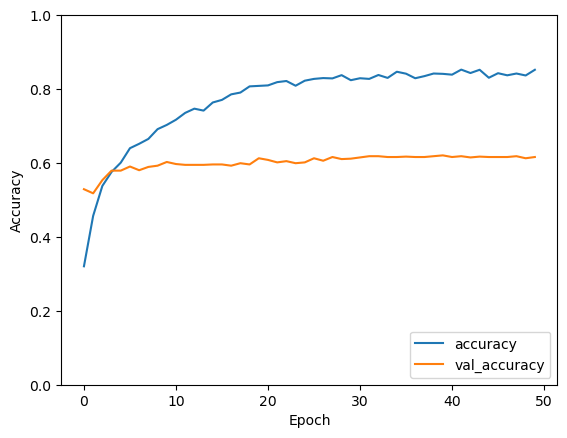

In [32]:
#plots training accuracy vs. validation accuracy over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

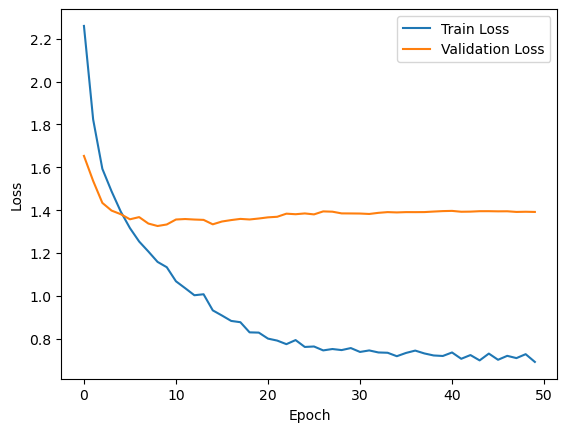

In [33]:
#plots training loss vs. validation loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### 6. Make Predictions

In [35]:
#predicts the class probabilities for the test dataset
predictions = mlp_model.predict(X_test_pca)
predicted_labels = np.argmax(predictions, axis=1)  #gets the class with the highest probability
true_labels = np.argmax(test_labels_one_hot, axis=1)  #converts one-hot encoded labels to class labels

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### 7. Generate Confusion Matrix

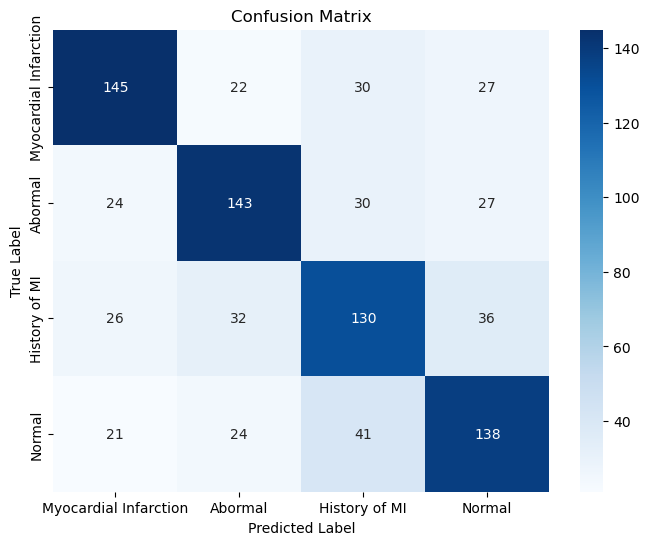

In [37]:
#generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Myocardial Infarction', 'Abormal', 'History of MI', 'Normal'],
            yticklabels=['Myocardial Infarction', 'Abormal', 'History of MI', 'Normal'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### 8. Generate Classification Report

In [39]:
#generate classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Myocardial Infarction', 'Abormal', 'History of MI', 'Normal']))

Classification Report:
                       precision    recall  f1-score   support

Myocardial Infarction       0.67      0.65      0.66       224
              Abormal       0.65      0.64      0.64       224
        History of MI       0.56      0.58      0.57       224
               Normal       0.61      0.62      0.61       224

             accuracy                           0.62       896
            macro avg       0.62      0.62      0.62       896
         weighted avg       0.62      0.62      0.62       896



### 9. Generate ROC curves and AUC Scores

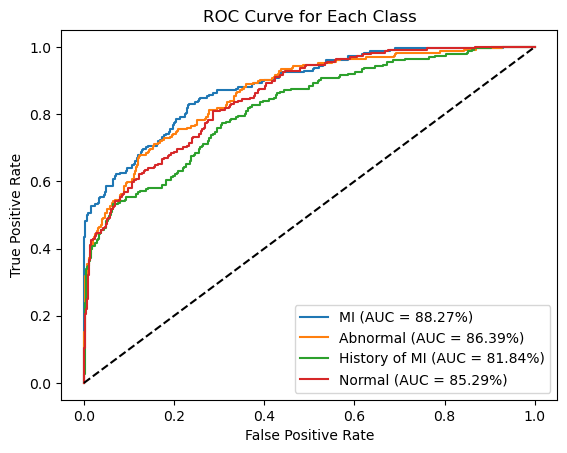

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

#binarize labels for multi-class ROC curve
binarized_labels = label_binarize(true_labels, classes=[0, 1, 2, 3])
n_classes = binarized_labels.shape[1]

#define class labels
class_labels = ['MI', 'Abnormal', 'History of MI', 'Normal']

#computes ROC curve and ROC area for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(binarized_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc*100:.2f}%)')

plt.plot([0, 1], [0, 1], 'k--')  #diagonal line for random classifier
#plots the roc curve for each class
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()